# Analysing single-cell RNA-sequencing Data

This tutorial is based on the vignette created by Johannes Griss (2021-10-26
) https://www.bioconductor.org/packages/release/bioc/vignettes/ReactomeGSA/inst/doc/analysing-scRNAseq.html

## Introduction
The ReactomeGSA package is a client to the web-based Reactome Analysis System. Essentially, it performs a gene set analysis using the latest version of the Reactome pathway database as a backend.

This vignette shows how the ReactomeGSA package can be used to perform a pathway analysis of cell clusters in single-cell RNA-sequencing data.

## Citation
To cite this package, use

Griss J. ReactomeGSA, https://github.com/reactome/ReactomeGSA (2019)

## Installation
The `ReactomeGSA` package can be directly installed from Bioconductor:

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!require(ReactomeGSA))
  BiocManager::install("ReactomeGSA")
#> Loading required package: ReactomeGSA

# install the ReactomeGSA.data package for the example data
if (!require(ReactomeGSA.data))
  BiocManager::install("ReactomeGSA.data")

Bioconductor version '3.12' is out-of-date; the current release version '3.14'
  is available with R version '4.1'; see https://bioconductor.org/install

Loading required package: ReactomeGSA

Loading required package: ReactomeGSA.data

Loading required package: limma

Loading required package: edgeR

Loading required package: Seurat

Attaching SeuratObject



For more information, see https://bioconductor.org/install/.

## Example data
As an example we load single-cell RNA-sequencing data of B cells extracted from the dataset published by Jerby-Arnon *et al.* (Cell, 2018).

Note: This is not a complete Seurat object. To decrease the size, the object only contains gene expression values and cluster annotations.

In [3]:
library(ReactomeGSA.data)
data(jerby_b_cells)

jerby_b_cells
#> An object of class Seurat 
#> 23686 features across 920 samples within 1 assay 
#> Active assay: RNA (23686 features, 0 variable features)

An object of class Seurat 
23686 features across 920 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)

# Extracting counts table and metadata

In [4]:
metadata <- jerby_b_cells@meta.data
head(metadata)
saveRDS(object = metadata, file = file.path( ".", "Single-Cell", "jerby_b_cells_metadata.RDS"))
write.csv(metadata, row.names = TRUE, file = file.path( ".", "Single-Cell", "jerby_b_cells_metadata.csv"), quote = FALSE)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
cy53_1_CD45_neg_H12_S384_comb,cy53,50508,8124
Cy81_FNA_CD45_G01_S265_comb,Cy81,292554,3301
cy94_cd45pos_F03_S159_comb,cy94,240094,4246
cy79_p4_CD45_pos_PD1_pos_F03_S351_comb,cy79,177665,3824
cy94_cd45pos_C05_S125_comb,cy94,830771,7004
CY89A_CD45_POS_6_H05_S185_comb,CY89A,82518,2905


In [5]:
counts <- jerby_b_cells@assays$RNA@counts
head(counts[1:3, 1:5])
saveRDS(object = counts, file = file.path( ".", "Single-Cell", "jerby_b_cells_counts.RDS"))
write.csv(counts, row.names = TRUE, file = file.path( ".", "Single-Cell", "jerby_b_cells_counts.csv"), quote = FALSE)

3 x 5 sparse Matrix of class "dgCMatrix"
         cy53_1_CD45_neg_H12_S384_comb Cy81_FNA_CD45_G01_S265_comb
C9orf152                             .                           .
RPS11                               93                         419
ELMO2                                2                           .
         cy94_cd45pos_F03_S159_comb cy79_p4_CD45_pos_PD1_pos_F03_S351_comb
C9orf152                          .                                      .
RPS11                           113                                    238
ELMO2                            67                                      .
         cy94_cd45pos_C05_S125_comb
C9orf152                          .
RPS11                           900
ELMO2                             .

How to create Seurat Object from data in text comma separated values (csv) format.

In [6]:

counts <- read.csv(  file = file.path( ".", "Single-Cell", "jerby_b_cells_counts.csv"))
# Set first column as row names an dremove it 
rownames(counts) <- counts[,"X"]
counts <- counts[,setdiff(colnames(counts), "X")]


metadata <- read.csv( file = file.path( ".", "Single-Cell", "jerby_b_cells_metadata.csv"))
rownames(metadata) <- metadata[,"X"]
metadata <- metadata[,setdiff(colnames(metadata), "X")]

jerby_b_cells <- CreateSeuratObject( counts = counts, 
                                  meta.data = metadata)


## Convert `Seurat` to `sce` object

In [13]:
jerby_b_cells.sce <- as.SingleCellExperiment(jerby_b_cells)
jerby_b_cells.sce

class: SingleCellExperiment 
dim: 23686 920 
metadata(0):
assays(2): counts logcounts
rownames(23686): C9orf152 RPS11 ... CTSC AQP7
rowData names(0):
colnames(920): cy53_1_CD45_neg_H12_S384_comb
  Cy81_FNA_CD45_G01_S265_comb ... cy128_CD45pos_S168
  CY75_1_CD45_CD8_8__S371_comb_BCD8
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
altExpNames(0):

## Pathway analysis of cell clusters
The pathway analysis is at the very end of a scRNA-seq workflow. This means, that any Q/C was already performed, the data was normalized and cells were already clustered.

The ReactomeGSA package can now be used to get pathway-level expression values for every cell cluster. This is achieved by calculating the mean gene expression for every cluster and then submitting this data to a gene set variation analysis.

All of this is wrapped in the single `analyse_sc_clusters` function.

In [7]:
## -----------------------------------------------------------------------------
library(ReactomeGSA)

gsva_result <- analyse_sc_clusters(jerby_b_cells, 
                                    use_interactors = TRUE, # This is the default
                                    include_disease_pathways = TRUE,
                                    create_reactome_visualization = TRUE,
                                    create_reports = TRUE,
                                    report_email = TRUE,
                                    verbose = TRUE)


Calculating average cluster expression...

Converting expression data to string... (This may take a moment)

Conversion complete

Submitting request to Reactome API...

Compressing request data...

Reactome Analysis submitted succesfully

Converting dataset Seurat...

Mapping identifiers...

Performing gene set analysis using ssGSEA

Analysing dataset 'Seurat' using ssGSEA

Creating REACTOME visualization

Retrieving result...



The resulting object is a standard `ReactomeAnalysisResult` object.

In [8]:
gsva_result
#> ReactomeAnalysisResult object
#>   Reactome Release: 77
#>   Results:
#>   - Seurat:
#>     1729 pathways
#>     10862 fold changes for genes
#>   No Reactome visualizations available
#> ReactomeAnalysisResult

ReactomeAnalysisResult object
  Reactome Release: 78
  Results:
  - Seurat:
    2352 pathways
    7773 fold changes for genes
  No Reactome visualizations available

`pathways` returns the pathway-level expression values per cell cluster:

In [9]:
pathway_expression <- pathways(gsva_result)

# simplify the column names by removing the default dataset identifier
colnames(pathway_expression) <- gsub("\\.Seurat", "", colnames(pathway_expression))

pathway_expression[1:3,]

,Name,cy043,cy102,cy103,cy105,cy106,cy110,cy112,cy116,cy1211,⋯,CY88CD45,CY88CD45POS,CY89A,CY89COREQ1,CY89FNA,CY89NEG,cy94,CY94CD45POS,cy98,MGH00478
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R-HSA-1059683,Interleukin-6 signaling,0.03595786,0.10694047,0.1296952,0.1155994,0.12527146,0.09773796,0.09682869,0.09804331,0.09506169,⋯,0.1184485,0.1355839,0.1193090,0.1004320,0.09414832,0.07956359,0.1323674,0.1379925,0.09825269,0.10735109
R-HSA-109606,Intrinsic Pathway for Apoptosis,0.03316198,0.09165477,0.1033249,0.1042538,0.09615995,0.08637229,0.08637553,0.08335034,0.07971921,⋯,0.1047299,0.1008414,0.1076095,0.1058187,0.08507195,0.06334457,0.1025746,0.1077137,0.07953727,0.09784127
R-HSA-109703,PKB-mediated events,0.16736344,0.20765846,0.3137443,0.2618210,0.30147896,0.24829925,0.20619402,0.17720227,0.15013858,⋯,0.2528630,0.2327125,0.3246562,0.3627270,0.30713370,0.18717829,0.3215819,0.3514958,0.25348044,0.20682928


A simple approach to find the most relevant pathways is to assess the maximum difference in expression for every pathway:

In [10]:
# find the maximum differently expressed pathway
max_difference <- do.call(rbind, apply(pathway_expression, 1, function(row) {
    values <- as.numeric(row[2:length(row)])
    return(data.frame(name = row[1], min = min(values), max = max(values)))
}))

max_difference$diff <- max_difference$max - max_difference$min

# sort based on the difference
max_difference <- max_difference[order(max_difference$diff, decreasing = T), ]

head(max_difference)


,name,min,max,diff
,<chr>,<dbl>,<dbl>,<dbl>
R-HSA-2142696,Synthesis of Hepoxilins (HX) and Trioxilins (TrX),-0.4976489,0.4986795,0.9963285
R-HSA-166020,Transfer of LPS from LBP carrier to CD14,-0.4846377,0.4986795,0.9833172
R-HSA-166662,Lectin pathway of complement activation,-0.4833472,0.4993881,0.9827353
R-HSA-2855086,Ficolins bind to repetitive carbohydrate structures on the target cell surface,-0.4833472,0.4993881,0.9827353
R-HSA-5619108,Defective SLC27A4 causes ichthyosis prematurity syndrome (IPS),-0.4837359,0.4927536,0.9764895
R-HSA-5619049,Defective SLC40A1 causes hemochromatosis 4 (HFE4) (macrophages),-0.4812882,0.4872141,0.9685023


## Plotting the results
The ReactomeGSA package contains two functions to visualize these pathway results. The first simply plots the expression for a selected pathway:

For a better overview, the expression of multiple pathways can be shown as a heatmap using `gplots` `heatmap.2` function:

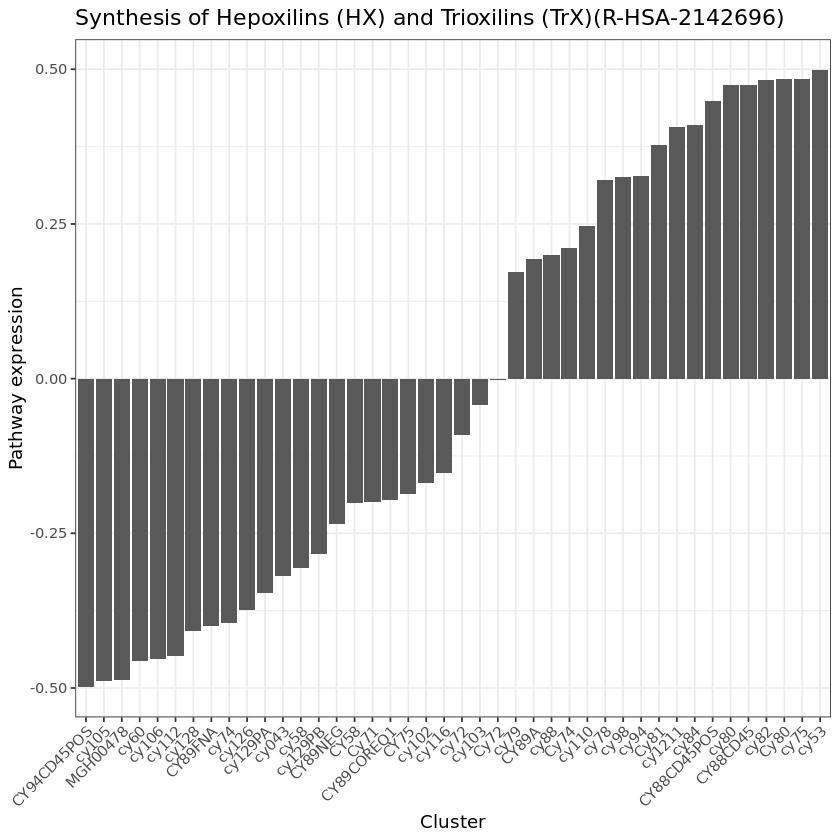

In [11]:
plot_gsva_pathway(gsva_result, pathway_id = rownames(max_difference)[1])

The plot_gsva_heatmap function can also be used to only display specific pathways:

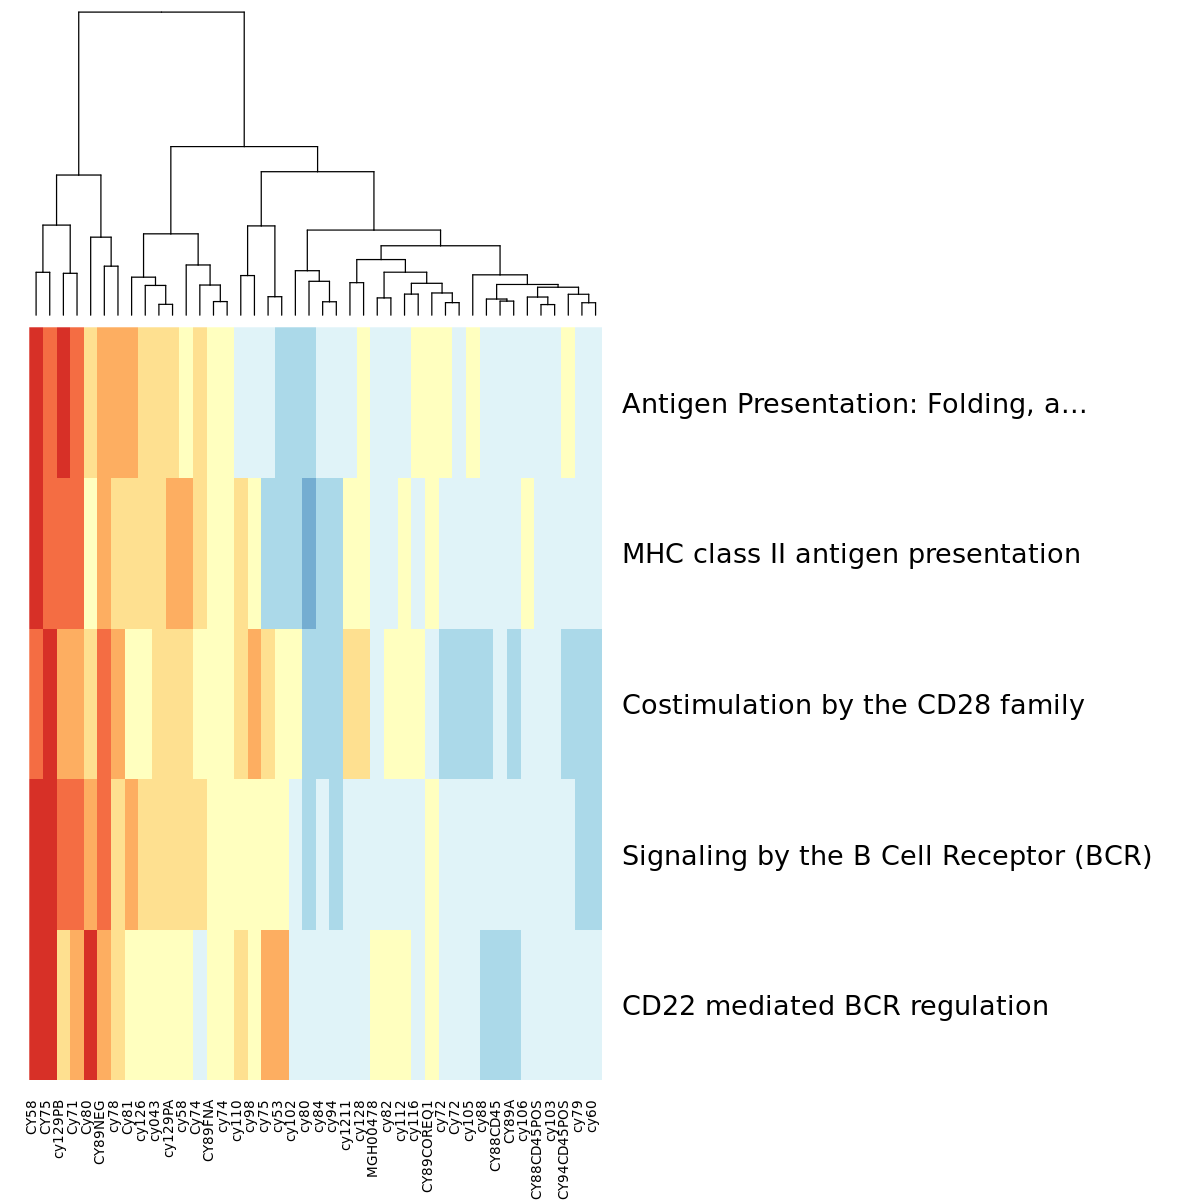

In [17]:
options(repr.plot.width=10, repr.plot.height=10)
# limit to selected B cell related pathways
relevant_pathways <- c("R-HSA-983170", "R-HSA-388841", "R-HSA-2132295", "R-HSA-983705", "R-HSA-5690714")
plot_gsva_heatmap(gsva_result, 
                  pathway_ids = relevant_pathways, # limit to these pathways
                  margins = c(6,30), # adapt the figure margins in heatmap.2
                  dendrogram = "col", # only plot column dendrogram
                  scale = "row", # scale for each pathway
                  key = FALSE, # don't display the color key
                  lwid=c(0.1,4)) # remove the white space on the left


This analysis shows us that cluster 8 has a marked up-regulation of B Cell receptor signalling, which is linked to a co-stimulation of the CD28 family. Additionally, there is a gradient among the cluster with respect to genes releated to antigen presentation.

Therefore, we are able to further classify the observed B cell subtypes based on their pathway activity.

## Pathway-level PCA

The pathway-level expression analysis can also be used to run a Principal Component Analysis on the samples. This is simplified through the function `plot_gsva_pca`:

In [ ]:
options(repr.plot.width=10, repr.plot.height=7)
plot_gsva_pca(gsva_result)

In this analysis, cluster 11 is a clear outlier from the other B cell subtypes and therefore might be prioritised for further evaluation.



## Reactome Pathway Visualization

In [20]:
# Get the URL link to visualize the Reactome Pathways analysis results
reactome_links(gsva_result)

No Reactome links available




In [19]:
# Open the URL link to visualize the Reactome Pathways analysis results
open_reactome(gsva_result)

ERROR: Error in .local(x, ...): Result does not contain any visualizations.


## Additional Information
The following hyperlink provides a tutorial on how to perform single-cell analysis with Seurat, preform normalization and clustering on the data, prior to the Reactome pathways analysis. Please visit if you're interested. https://github.com/reactome/ReactomeGSA-tutorials/blob/master/notebooks/Jerby_Arnon_Seurat.ipynb

## Session Info

In [ ]:
sessionInfo()